# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
from layers import disp_to_depth

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"
# model_name = "mono_1024x320"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

device = torch.device("cuda")
# device = torch.device("cpu")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
encoder.to(device)

loaded_dict = torch.load(depth_decoder_path, map_location=device)
depth_decoder.load_state_dict(loaded_dict)
depth_decoder.to(device)

encoder.eval()
depth_decoder.eval();

In [3]:
import cv2
import time

cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('https://192.168.2.109:8080/video')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']

prev_ftime = 0
new_ftime = 0

while True:
    ret, frame = cap.read()

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb,(feed_width,feed_height))
    frame_pytorch = transforms.ToTensor()(frame_resized).unsqueeze(0)
    frame_cuda = frame_pytorch.to(device)

    with torch.no_grad():
        features = encoder(frame_cuda)
        outputs = depth_decoder(features)
    
    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
        (height, width), mode="bilinear", align_corners=False)
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    new_ftime = time.time()
    fps = 1/(new_ftime - prev_ftime)
    prev_ftime = new_ftime
    fps = str(int(fps))

    cv2.putText(disp_resized_np, fps, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('webcam',frame)
    # cv2.imshow('webcam',cv2.resize(frame,(860,640)))
    cv2.imshow('depth',disp_resized_np)
    # cv2.imshow('depth',cv2.resize(disp_resized_np,(860,640)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()

## Loading the test image and preprocessing

In [3]:
image_path = "assets/20220120-110735.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
input_cuda = input_image_pytorch.to(device)

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_cuda)
    outputs = depth_decoder(features)

# print(outputs)
# print(type(outputs))

disp = outputs[("disp", 0)]

# print(disp.shape)

## Plotting

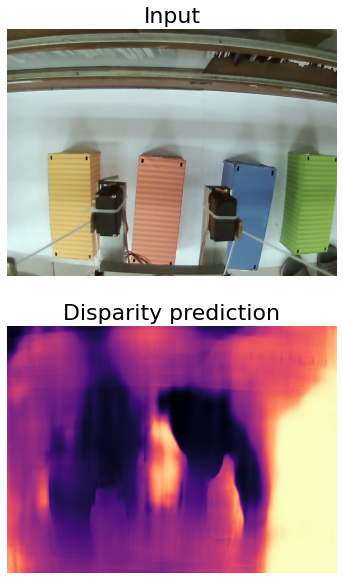

In [6]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)
scaled_disp, depth = disp_to_depth(disp_resized, 0.1, 100)
disp_not_resized = torch.nn.functional.interpolate(disp,(disp.shape[2],disp.shape[3]))

# print(disp_resized)
# print(disp_resized.shape)
# print(scaled_disp)
# print(scaled_disp.shape)
# print(depth)
# print(depth.shape)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)
# disp_resized_np = disp_not_resized.squeeze().cpu().numpy()
# vmax = np.percentile(disp_resized_np, 95)

# print(disp_resized_np)
# print(disp_resized_np.shape)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');